<a href="https://colab.research.google.com/github/GollyTicker/Food-Recognition-Challenge/blob/main/Starter_Kit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![AIcrowd-Logo](https://raw.githubusercontent.com/AIcrowd/AIcrowd/master/app/assets/images/misc/aicrowd-horizontal.png)

This dataset and notebook correspond to the [Food Recognition Challenge](https://www.aicrowd.com/challenges/food-recognition-challenge) being held on [AIcrowd](https://www.aicrowd.com/).

<p align="right"> Join the communty! <br><a href="https://discord.gg/GTckBMx"><img src="https://img.shields.io/discord/657211973435392011?style=for-the-badge" alt="chat on Discord"></a>
</p>

# <center> 🍕 Food Recognition Challenge: Detectron2 starter kit </center>

<center>This notebook aims to build a model for food detection and segmentation using <code>detectron2</code></center>

# How to use this notebook? 📝
1. **Copy the notebook**. This is a shared template and any edits you make here will not be saved. _You should copy it into your own drive folder._ For this, click the "File" menu (top-left), then "Save a Copy in Drive". You can edit your copy however you like.
2. **Make a submission**. Run all the code in the notebook to get a feel of how the notebook and the submission process works.
3. **Try tweaking the parameters**. If you are new to the problem, a great way to start is try tweaking the configuration flags, train your model and submit again.
4. **Diving into the code**. When you submit via this notebook, we create a repository on [gitlab.aicrowd.com](https://gitlab.aicrowd.com). You can check the code we generated based on this notebook and directly make changes you want there!


# Setup the notebook 🛠

If you are running this locally (instead of in Colab), then please use Conda and execute the setup instructions in estup-windows.txt. After that, you can continue with these setup instructions

In [1]:
# !bash <(curl -sL https://gitlab.aicrowd.com/jyotish/food-recognition-challenge-detectron2-baseline/raw/master/utils/setup-colab.sh)
!pip install -q numpy python-dotenv minio multiprocess scikit-image nbdime
!pip install -q cython aicrowd-api Pillow opencv-python
# !pip install -f https://download.pytorch.org/whl/cu101/torch_stable.html torch==1.5 torchvision==0.6
# !pip install -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/index.html detectron2==0.1.2

In [2]:
!pip install git+https://github.com/philferriere/cocoapi.git#subdirectory=PythonAPI

  Cloning https://github.com/philferriere/cocoapi.git to c:\users\s.sahoo\appdata\local\temp\pip-req-build-cj5c3zw_
  Resolved https://github.com/philferriere/cocoapi.git to commit 2929bd2ef6b451054755dfd7ceb09278f935f7ad


  Running command git clone -q https://github.com/philferriere/cocoapi.git 'C:\Users\s.sahoo\AppData\Local\Temp\pip-req-build-cj5c3zw_'


In [3]:
!pip install -qq fastbook
import fastbook
fastbook.setup_book()

In [4]:
from pathlib import Path
import os
import json
from multiprocess import Pool # Attention: We use multiprocess instead of multiprocessing library.
# This works for parallelism on Windows in Jupyter

from tqdm.notebook import tqdm
from pycocotools.coco import COCO
from torch import tensor
import numpy as np
import cv2
import PIL
import platform
import skimage
import random
import skimage.io as io
import matplotlib.pyplot as plt
%matplotlib inline

from poolstore import *

from fastbook import *
#hide
# test gpu is used
import torch
print(torch.cuda.is_available())
# assert torch.cuda.is_available()

WINDOWS = platform.system() == 'Windows'
DEVICE = torch.device("cuda")
PAR_PROCS = 3 if WINDOWS else None

True


##### Parallel Processing
`multiprocessing` had execution issues on Windows within jupyter. Hence, this notebook uses `multiprocess`. However, to ensure, that all dependencies (variables) are useable in the worker task, I created a script `poolstore` which is imported in the cells here and in the worker task. The variables need to be stored to disk via `storePool(myVar, "myVar")` and restored in the worker function via `loadPool("myVar", globals())`. **Changes in global variables are not reflected across worker processes and the main process.**.

In [5]:
def prepareTask(taskVarName):
  storePool(globals()[taskVarName], "currentTask")
  def worker(*args):
    from poolstore import loadPool
    loadPool("currentTask", globals())
    return currentTask(*args)
  return worker

data = np.random.random((2,10))
constdata = np.random.random((10))
constdata2 = np.random.random((10))

def subfunction(a, b):
  return a * b + constdata2

def exampleTask(xs):
  return subfunction(xs, constdata)[:3]
  
def doStuff(data):
  result = []
  
  f = prepareTask("exampleTask")

  with Pool(PAR_PROCS) as p:
    with tqdm(total=len(data)) as progress_bar:
      for funcres in p.imap(f, data):
        result.append(funcres)
        progress_bar.update(1)

  return result

if np.array(doStuff(data)).shape == (2,3):
  print("Parallel processing works.")

  0%|          | 0/2 [00:00<?, ?it/s]

Parallel processing works.


#### Downloading Data

In [6]:
import urllib
if WINDOWS:
  urllib.request.urlretrieve("https://github.com/stedolan/jq/releases/download/jq-1.6/jq-win64.exe", "jq.exe")
else:
  os.system("wget -q -O jq https://github.com/stedolan/jq/releases/download/jq-1.6/jq-linux64 && chmod +x jq")

In [7]:
#!wget -q -nv https://datasets.aicrowd.com/default/aicrowd-public-datasets/food-recognition-challenge/v0.4/train-v0.4.tar.gz
#!wget -q -nv https://datasets.aicrowd.com/default/aicrowd-public-datasets/food-recognition-challenge/v0.4/val-v0.4.tar.gz

In [8]:
def path_exists(path):
  return Path(path).exists()

def wget(url):
  dest = url.split('/')[-1]
  if path_exists(dest):
    print(f"{dest} already exists.")
  else:
    print("Downloading",url,end=" ")
    urllib.request.urlretrieve(url, dest)
    print("Done.")

In [9]:
wget("https://s3.eu-central-1.wasabisys.com/aicrowd-public-datasets/myfoodrepo/round-1/train.tar.gz")
wget("https://s3.eu-central-1.wasabisys.com/aicrowd-public-datasets/myfoodrepo/round-1/test_images.tar.gz")
wget("https://s3.eu-central-1.wasabisys.com/aicrowd-public-datasets/myfoodrepo/round-1/val.tar.gz")

train.tar.gz already exists.
test_images.tar.gz already exists.
val.tar.gz already exists.


In [10]:
def ls(path, n=10000):
  for f in os.listdir(Path(path))[:n]:
    print(f)

print("Current directory:", os.getcwd())
ls(".")

Current directory: C:\Users\s.sahoo\Documents\privat\Artificial Intelligence\Food-Recognition-Challenge
.git
.gitignore
.ipynb_checkpoints
Anaconda Prompt (Anaconda3).lnk
curr
jq.exe
pool-store
poolstore.py
README.md
Starter_Kit.ipynb
swnt-storage-credentials.txt
test_images
test_images.tar.gz
train
train.tar.gz
val
val.tar.gz
windows-setup.txt
__pycache__


In [11]:
import tarfile

def untar_idempotent(file):
  ext = ".tar.gz"
  assert file.endswith(ext)
  filename = file[:-len(ext)]
  if path_exists(filename):
    print(file,"already extracted.")
  else:
    with tarfile.open(file, "r:gz") as tar:
      tar.extractall()
    print(file,"extracted.")

for file in os.listdir("."):
  if file.endswith('.tar.gz'):
    untar_idempotent(file)

test_images.tar.gz already extracted.
train.tar.gz already extracted.
val.tar.gz already extracted.


In [12]:
ls("train")

if WINDOWS:
  print("Preview of annotations.json not on Windows.")
else:
  os.system("cat train/annotations.json | ./jq . | head -n 50")

annotations.json
images
segmentations
Preview of annotations.json not on Windows.


# Configure static variables 📎

On, Colab, if you are using a S3 storage to store models, intermediate data etc., then you can point to it here.

If it does not exist, then the notebook will always recompute stuff instead of caching them on the S3.

If you are executing this locally, you do not need this.

In [13]:
# The credentials for the storage as expected to be read from this file in Google Drive.
# You can populate that file using:

# echo "USER=<user>" >> "/content/gdrive/My Drive/<path-to-file>"
# echo "PASSWORD=<password>" >> "/content/gdrive/My Drive/<path-to-file>"
# echo "URL=<endpoint-url>" >> "/content/gdrive/My Drive/<path-to-file>"
# echo "PATH_WITH_BUCKET=some-bucket/some/path/in/bucket/without/trailing/slash" >> "/content/gdrive/My Drive/<path-to-file>"

STORAGE_CREDENTIALS_PATH = Path("/content/gdrive/My Drive/swnt-storage-credentials.txt") if not WINDOWS else Path("swnt-storage-credentials.txt")

STORAGE = {
  "USER": None,
  "PASSWORD": None,
  "URL": None,
  "BUCKET": None,
  "PATH": None
}

In [14]:
from dotenv import dotenv_values
from minio import Minio, S3Error
from minio.deleteobjects import DeleteObject
STORAGE_AVAILABLE=False

storage_client = None

# Note: All invocations of storage_client need to explicitly map between platform dependent paths
# and s3 key (always posix). This should happen only directly at client call sites
def to_s3key(path):
  "a\\b\\c.txt and a/b/c.txt -> to a/b/c.txt"
  return str(Path(path).as_posix())

def from_s3key(key):
  "a/b/c.txt -> platform-dependent path"
  return Path(key)

def extract_storage_credentials():
  credentials = dotenv_values(STORAGE_CREDENTIALS_PATH)
  
  try:
    STORAGE["USER"] = credentials["USER"]
    STORAGE["PASSWORD"] = credentials["PASSWORD"]
    STORAGE["URL"] = credentials["URL"]
  
    path_with_bucket = credentials["PATH_WITH_BUCKET"]
    STORAGE["BUCKET"] = path_with_bucket.split("/")[0]
    STORAGE["PATH"] = Path(path_with_bucket[len(STORAGE["BUCKET"])+1:])

    print("Found storage credentials with user", STORAGE["USER"],"at", STORAGE["URL"])
  
  except KeyError as e:
    print(f"Please ensure USER, PASSWORD and URL are defined in the file {STORAGE_CREDENTIALS_PATH}?")
    raise e

def make_storage_client():
  global storage_client
  storage_client = Minio(
      STORAGE["URL"],
      access_key = STORAGE["USER"],
      secret_key = STORAGE["PASSWORD"]
  )

def storage_list_objects_with_prefix(prefix):
  """Attention! You need to use from_s3key(error[i].object_name) to retrieve the platform dependent path"""
  prefix = to_s3key(prefix)
  return storage_client.list_objects(STORAGE["BUCKET"], prefix=prefix, recursive=True)

def storage_remove_all_with_prefix(prefix):
  prefix = to_s3key(prefix)
  test_objects_to_delete = storage_list_objects_with_prefix(prefix)
  delete_objects_list = map(lambda obj: DeleteObject(obj.object_name), test_objects_to_delete)
  errors = storage_client.remove_objects(STORAGE["BUCKET"], delete_objects_list)
  return errors

def storage_remove_object_idempotent(key):
  key = to_s3key(key)
  try:
    storage_client.remove_object(STORAGE["BUCKET"], key)
  except S3Error as e:
    if e.code != "NoSuchKey":
      raise e

def storage_upload_single_file(file, key, metadata=None):
  file_size = os.stat(file).st_size
  with open(file, "rb") as f:
    storage_upload_bytestream(key, f, length=file_size, metadata=metadata)

def storage_upload_bytestream(key, stream, length, metadata=None, debug=False):
    key = to_s3key(key)
    if debug:
      print(f"Storing blob of length {length} at {key}")
    storage_client.put_object(STORAGE["BUCKET"], key, stream, length=length, metadata=metadata)
    
def silently(func):
  try:
    func()
  except Exception as e:
    pass

def storage_get_object_response_action(key, action):
  key = to_s3key(key)
  try:
      response = storage_client.get_object(STORAGE["BUCKET"], key)
      return action(response)
  finally:
      silently(lambda: response.close())
      silently(lambda: response.release_conn())

def storage_get_object_as_blob(key):
  key = to_s3key(key)
  return storage_get_object_response_action(key, lambda response: response.data)
      
def storage_object_exists(key):
  key = to_s3key(key)
  try:
    storage_client.stat_object(STORAGE["BUCKET"], key)
    return True
  except S3Error as e:
    if e.code == "NoSuchKey":
      return False
    else:
      raise e
  
def test_storage_with_files():
  test_suffix = str(random.randint(100000,999999))
  test_prefix = STORAGE['PATH'] / "delete-me---storage-access-test-tmp-"
  test_path = f"{test_prefix}-{test_suffix}"
  test_content = b"sdlfslife"
  
  storage_upload_bytestream(test_path, io.BytesIO(test_content), len(test_content))

  result = storage_get_object_as_blob(test_path)

  assert test_content == result

  errors = list( storage_remove_all_with_prefix(test_prefix) )
  
  for err in errors:
    print("Error while deleting:", err)
  assert len(errors) == 0

  print("Probing of storage successful.")

def test_storage():
  try:
    make_storage_client()
    test_storage_with_files()
  except Exception as e:
    print("Failed to write, read or delete a test object in storage.")
    raise e


if STORAGE_CREDENTIALS_PATH.exists():
  extract_storage_credentials()

  test_storage()

  STORAGE_AVAILABLE=True

if STORAGE_AVAILABLE:
  print(f"STORAGE_AVAILABLE = {STORAGE_AVAILABLE}. Some functions will cache results.")
else:
  print(f"STORAGE_AVAILABLE = {STORAGE_AVAILABLE}. All computed results will be lost when your Colab is closed!")
  print("To store and cache results, please specify a S3 compatible storage.")

Found storage credentials with user d12d9ba117aba1286859 at swaneet.eu:9000
Probing of storage successful.
STORAGE_AVAILABLE = True. Some functions will cache results.


In [15]:
import os
STORAGE_MIRRORS = STORAGE["PATH"] / "mirrors"

def storage_store_directory_idempotent(dir, name, debug=False):
  "Mirrors the given directory onto the storage. If run a second time, the backup already exists and it is then not overwritten."
  mirrorRoot = to_s3key(STORAGE_MIRRORS / name)

  for _ in storage_list_objects_with_prefix(mirrorRoot):
    print(f"Mirrors: Name {name} is already defined and will not be stored again.")
    return

  print(f"Storing directory for name {name}.")

  for root, dirs, files in os.walk(dir):
    for file in files:
      relpath = Path(root) / file
      if debug:
        print("Save",relpath," -> ",mirrorRoot/relpath)
      storage_upload_single_file(file=relpath, key=mirrorRoot/relpath)

def print_on_error(msg, errors):
  for err in errors:
    print(msg, err)

def storage_remove_stored_directory(name):
  print_on_error("Error removing", storage_remove_all_with_prefix(STORAGE_MIRRORS / name))
  print(f"Removed stored {name}.")

In [16]:
def set_file_contents(file, bytes):
  os.makedirs(os.path.dirname(file), exist_ok=True)
  with open(file,"wb+") as f:
    f.write(bytes)
    
def remove_recursive_force(dir):
  shutil.rmtree(dir, ignore_errors=True)

if "test directories":
  d = Path("test-dir")
  
  for dr in [d, d / "1", d / "2"]:
    os.makedirs(dr, exist_ok=True)

  set_file_contents(d/"1"/"1.txt", b"1.1")
  set_file_contents(d/"2"/"2.txt", b"2.2")
  set_file_contents(d/"2"/"3.txt", b"2.3")

  if STORAGE_AVAILABLE:
    storage_store_directory_idempotent("test-dir", name="test", debug=True)
    storage_remove_stored_directory(name="test")
    remove_recursive_force("test-dir")

Storing directory for name test.
Save test-dir\1\1.txt  ->  Artificial_Intelligence\FoodRecChallenge\colab-storage\mirrors\test\test-dir\1\1.txt
Save test-dir\2\2.txt  ->  Artificial_Intelligence\FoodRecChallenge\colab-storage\mirrors\test\test-dir\2\2.txt
Save test-dir\2\3.txt  ->  Artificial_Intelligence\FoodRecChallenge\colab-storage\mirrors\test\test-dir\2\3.txt
Removed stored test.


In [17]:
STORAGE_ARTIFACTS = STORAGE["PATH"] / "artifacts"

def storage_store_artifact_by_name(artifact_relpath, name, force=False):
  assert "/" not in str(name) and "\\" not in str(name), "Names may not contain any / or \\."
  
  path = to_s3key(STORAGE_ARTIFACTS / name)
  normalised_relpath = to_s3key(artifact_relpath)

  exists = storage_object_exists(path)
  
  save_file = lambda: storage_upload_single_file(file=artifact_relpath, key=path, metadata = {"relpath": normalised_relpath})
  
  if exists and not force:
    print(f"Artifact with name {name} is already defined and will not be stored again.")
    return
  elif exists and force:
    save_file()
    print(f"Artifact with name {name} was overwritten in storage at {path}.")
  else:
    save_file()
    print(f"Stored artifact for name {name} at {path}.")
    
def storage_retrieve_artifact_by_name(name):
  blob, normalised_relpath = storage_get_object_response_action(
    key= STORAGE_ARTIFACTS / name,
    action = lambda response: (response.data, response.headers.get("x-amz-meta-relpath", None)) # x-amz-meta-
  )
  if normalised_relpath is None:
    raise ValueError(f"Stored artifacts must have metadata relpath defined! Name {name}")
    
  relpath = from_s3key(normalised_relpath)
  set_file_contents(relpath, blob)
  print(f"Restored artifact with name {name} to {relpath}.")
    
def storage_list_artifacts():
  return [ from_s3key(obj.object_name).name for obj in storage_list_objects_with_prefix(STORAGE_ARTIFACTS) ]

def storage_remove_artifact_idempotent(name):
  storage_remove_object_idempotent(STORAGE_ARTIFACTS / name)

In [18]:
# artifact storage test

if "artifact test":
  test_path = Path("file-test")/"path.txt"
  os.makedirs("file-test", exist_ok=True)
  contents = b"abcdef"
  set_file_contents(test_path, contents)

  storage_store_artifact_by_name(test_path, "test-file-1", force=True)
  
  assert "path.txt" in list(os.listdir("file-test"))
  remove_recursive_force("file-test")
  assert "file-test" not in list(os.listdir("."))
  
  storage_retrieve_artifact_by_name("test-file-1")
  assert "path.txt" in list(os.listdir("file-test"))
  with open(test_path,"rb") as f:
    assert f.read() == contents
    
  assert "test-file-1" in storage_list_artifacts()
  storage_remove_artifact_idempotent("test-file-1")
  assert "test-file-1" not in storage_list_artifacts()

  remove_recursive_force("file-test")

Stored artifact for name test-file-1 at Artificial_Intelligence/FoodRecChallenge/colab-storage/artifacts/test-file-1.
Restored artifact with name test-file-1 to file-test\path.txt.


In [19]:
# todo. continue here
if STORAGE_AVAILABLE:
  pass # storage_load_directory_overwrite_local("test-dir", name="test", debug=True)

In [20]:
class Paths:
  DATASET_DIR = Path(".")
  
  TRAIN_DATA_DIR = DATASET_DIR/"train"
  TRAIN_IMAGES_DIR = TRAIN_DATA_DIR/"images"
  TRAIN_ANNOTATIONS = TRAIN_DATA_DIR/"annotations.json"
  TRAIN_MULTI_SEG_DIR = TRAIN_DATA_DIR/"segmentations"
  
  VAL_DATA_DIR = DATASET_DIR/"val"
  VAL_ANNOTATIONS = VAL_DATA_DIR/"annotations.json"
  VAL_IMAGES_DIR = VAL_DATA_DIR/"images"
  VAL_MULTI_SEG_DIR = VAL_DATA_DIR/"segmentations"

  CURR_DATA_DIR = DATASET_DIR/"curr"
  CURR_IMAGES_DIR = CURR_DATA_DIR/"images"
  CURR_ANNOTATIONS = CURR_DATA_DIR/"annotations.json"
  CURR_MULTI_SEG_DIR = CURR_DATA_DIR/"segmentations"


class DatasetLabels:
  TRAIN = "dataset_train"
  VAL = "dataset_val"

remove_recursive_force(Paths.CURR_IMAGES_DIR)
for dirs in [Paths.CURR_IMAGES_DIR,Paths.TRAIN_MULTI_SEG_DIR,Paths.VAL_MULTI_SEG_DIR,Paths.CURR_MULTI_SEG_DIR]:
  os.makedirs(dirs,exist_ok=True)

In [21]:
# this cell needs to be updated

if False:
  GDRIVE_MIRROR_ROOT = gdrive/"Food Challenge"/"persistent"/"mirror"
  os.makedirs(GDRIVE_MIRROR_ROOT,exist_ok=True)

  def store_directory_to_google_drive(relative_dir):
    destination = GDRIVE_MIRROR_ROOT/relative_dir
    print(f"Storing {relative_dir} -> {destination} (target removed before copy)")
    shutil.rmtree(destination, ignore_errors=True)
    shutil.copytree(relative_dir,destination)

  def restore_directory_from_google_drive(relative_dir):
    source = GDRIVE_MIRROR_ROOT/relative_dir
    print(f"Restoring {relative_dir} <- {source} (target removed before copy)")
    shutil.rmtree(relative_dir, ignore_errors=True)
    shutil.copytree(source,relative_dir)

In [22]:
# restore precomputed segmentation masks
if False and "we don't want to restore the segmentation masks from google drive, since this is slow. It's slower than computing them directly!":
  try:
    restore_directory_from_google_drive(Paths.TRAIN_MULTI_SEG_DIR)
  except Exception as e:
    e.printStackTrace()

# Packages 🗃

Import here all the packages you need to define your model. 

In [23]:
"""from detectron2.data.datasets import register_coco_instances
import detectron2
from detectron2.utils.logger import setup_logger
from detectron2.utils.visualizer import Visualizer
from detectron2.utils.visualizer import ColorMode
from detectron2.data import MetadataCatalog
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
from detectron2.engine import DefaultPredictor
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
from detectron2 import model_zoo
from detectron2.utils.events import get_event_storage
from detectron2.engine import HookBase
""";

# Loading the data 📲

In [24]:
with open(Paths.TRAIN_ANNOTATIONS) as fp:
  annotations = json.load(fp)
  print(annotations.keys())

dict_keys(['categories', 'info', 'images', 'annotations'])


## Helper functions to clean the dataset

First, we will see if all the annotations in the dataset are properly aligned with the images. These helper functions will let us do that.

In [25]:
# LIMITATION: multiprocess does not seem to support global variables... all functions seem to need to be stand-alone...

def validate_annotation(annotation):
  """Check the image dimensions and fix them if needed
  """
  import os
  filepath = annotation.get("file_name")
  if not os.path.exists(filepath):
    print("Skipping", filepath)
    return annotation
  img = cv2.imread(filepath)
  if img.shape[0] != annotation.get("height") or img.shape[1] != annotation.get("width"):
    annotation["height"], annotation["width"] = annotation["width"], annotation["height"]
  return annotation


def clean_annotations(annotation_images):
  """Read the image dimensions and fix them in parallel
  """
  annotated_images = []

  with Pool() as p:
    total_images = len(annotation_images)

    with tqdm(total=total_images) as progress_bar:
      for annotation in p.imap(validate_annotation, annotation_images):
        annotated_images.append(annotation)
        progress_bar.update(1)

  return annotated_images

## Clean the training data 🧹

In [26]:
image_dir = Paths.TRAIN_IMAGES_DIR
annotations["images"] = clean_annotations(annotations.get("images"))

with open(Paths.TRAIN_ANNOTATIONS, "w") as fp:
  json.dump(annotations, fp)

  0%|          | 0/5545 [00:00<?, ?it/s]

## Clean the validation data 🧹

In [27]:
image_dir = Paths.VAL_IMAGES_DIR

with open(Paths.VAL_ANNOTATIONS) as fp:
  validation_annotations = json.load(fp)

validation_annotations["images"] = clean_annotations(validation_annotations.get("images"))

with open(Paths.VAL_ANNOTATIONS, "w") as fp:
  json.dump(validation_annotations, fp)

  0%|          | 0/291 [00:00<?, ?it/s]

# My baseline model

In [28]:
coco = COCO(Paths.TRAIN_ANNOTATIONS)

loading annotations into memory...
Done (t=0.68s)
creating index...
index created!


In [29]:
category_ids = coco.loadCats(coco.getCatIds())
category_names = [_["name"] for _ in category_ids]

N_CLASSES = len(category_ids)

image_ids = coco.getImgIds()

annotation_ids = coco.getAnnIds()
annotations = coco.loadAnns(annotation_ids)

print("Categories: ",", ".join(category_names))

print("Image ids: ", image_ids[:10],"...")

print("Annotation:" , annotations[0].keys())


Categories:  bread-wholemeal, potatoes-steamed, broccoli, butter, hard-cheese, water, banana, wine-white, bread-white, apple, pizza-margherita-baked, salad-leaf-salad-green, zucchini, water-mineral, coffee-with-caffeine, avocado, tomato, dark-chocolate, white-coffee-with-caffeine, egg, mixed-salad-chopped-without-sauce, sweet-pepper, mixed-vegetables, mayonnaise, rice, chips-french-fries, carrot, tomato-sauce, cucumber, wine-red, cheese, strawberries, espresso-with-caffeine, tea, chicken, jam, leaf-spinach, pasta-spaghetti, french-beans, bread-whole-wheat
Image ids:  [16387, 49157, 16394, 49164, 49166, 16398, 49168, 49171, 16409, 49179] ...
Annotation: dict_keys(['id', 'image_id', 'category_id', 'segmentation', 'area', 'bbox', 'iscrowd'])


In [30]:
N = 5545
choice = np.linspace(0,len(image_ids)-1,N,dtype=np.int16)
tiny_train_imids = [image_ids[ci] for ci in choice]
# tiny_train_imids, N = [12886,22949,49145,54634], 4
assert len(tiny_train_imids) == N

# create currently trained on dataset
for imid in tiny_train_imids:
  im = coco.loadImgs(imid)[0]
  shutil.copy(Paths.TRAIN_IMAGES_DIR/im['file_name'], Paths.CURR_IMAGES_DIR/im['file_name'])
  
shutil.copy(Paths.TRAIN_ANNOTATIONS, Paths.CURR_ANNOTATIONS)


testN = len(os.listdir(Paths.CURR_IMAGES_DIR))
assert testN == N, f"Expected {N} images in current training folder. But found {testN}. Please ensure, that you don't have cached images"

In [31]:
ls("curr")
ls("curr/images", n=50)

annotations.json
images
m00-resnet34-epoch5.pkl
models
segmentations
006446.jpg
006452.jpg
006483.jpg
006489.jpg
006493.jpg
006497.jpg
006498.jpg
006508.jpg
006512.jpg
006514.jpg
006516.jpg
006519.jpg
006523.jpg
006535.jpg
006537.jpg
006539.jpg
006540.jpg
006548.jpg
006556.jpg
006559.jpg
006567.jpg
006573.jpg
006574.jpg
006576.jpg
006578.jpg
006580.jpg
006581.jpg
006592.jpg
006596.jpg
006607.jpg
006624.jpg
006626.jpg
006628.jpg
006638.jpg
006639.jpg
006645.jpg
006663.jpg
006665.jpg
006671.jpg
006681.jpg
006686.jpg
006726.jpg
006747.jpg
006763.jpg
006767.jpg
006770.jpg
006773.jpg
006774.jpg
006775.jpg
006782.jpg


In [32]:
[catdict["name"] for catdict in category_ids]

['bread-wholemeal',
 'potatoes-steamed',
 'broccoli',
 'butter',
 'hard-cheese',
 'water',
 'banana',
 'wine-white',
 'bread-white',
 'apple',
 'pizza-margherita-baked',
 'salad-leaf-salad-green',
 'zucchini',
 'water-mineral',
 'coffee-with-caffeine',
 'avocado',
 'tomato',
 'dark-chocolate',
 'white-coffee-with-caffeine',
 'egg',
 'mixed-salad-chopped-without-sauce',
 'sweet-pepper',
 'mixed-vegetables',
 'mayonnaise',
 'rice',
 'chips-french-fries',
 'carrot',
 'tomato-sauce',
 'cucumber',
 'wine-red',
 'cheese',
 'strawberries',
 'espresso-with-caffeine',
 'tea',
 'chicken',
 'jam',
 'leaf-spinach',
 'pasta-spaghetti',
 'french-beans',
 'bread-whole-wheat']

In [33]:
SEG_DTYPE = np.float32

fai_multi_cats_from_coco_ids = Pipeline([MultiCategorize(vocab=[catdict["id"] for catdict in category_ids]),
                                         OneHotEncode(c=N_CLASSES),
                                         Transform(enc = lambda tensor_mcat: np.array(tensor_mcat,dtype=SEG_DTYPE), dec = TensorMultiCategory, order=2)
                                         ])

coco_cat_id_to_name = lambda coco_cat_id : list(filter(lambda catdict: catdict["id"] == coco_cat_id, category_ids))[0]["name"]
fai_multi_cats_to_names = Transform(lambda fai_cats: list(map(coco_cat_id_to_name, fai_multi_cats_from_coco_ids.decode(fai_cats))))

print(category_ids[0])
print(category_ids[35])
print(category_ids[24])

print(fai_multi_cats_from_coco_ids)

example_categories = fai_multi_cats_from_coco_ids([1565,2099,1468])
print("bread-wholemeal,jam,rice ->", example_categories)

print("bread-wholemeal,jam,rice -> ", fai_multi_cats_to_names(example_categories))

{'id': 1565, 'name': 'bread-wholemeal', 'name_readable': 'Bread, wholemeal', 'supercategory': 'food'}
{'id': 2099, 'name': 'jam', 'name_readable': 'Jam', 'supercategory': 'food'}
{'id': 1468, 'name': 'rice', 'name_readable': 'Rice', 'supercategory': 'food'}
Pipeline: MultiCategorize -- {'vocab': [1565, 1010, 1085, 2053, 1310, 2578, 1154, 2620, 1566, 1151, 2939, 1040, 1070, 2580, 2512, 1056, 1069, 2131, 2521, 2022, 1026, 1068, 1022, 2750, 1468, 1013, 1078, 2738, 1061, 2618, 1311, 1163, 2504, 2498, 1788, 2099, 1032, 1505, 1058, 1554], 'sort': False, 'add_na': False} -> OneHotEncode -- {'c': 40} -> <lambda>
bread-wholemeal,jam,rice -> [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
bread-wholemeal,jam,rice ->  ['bread-wholemeal', 'rice', 'jam']


#### Analyse Categories

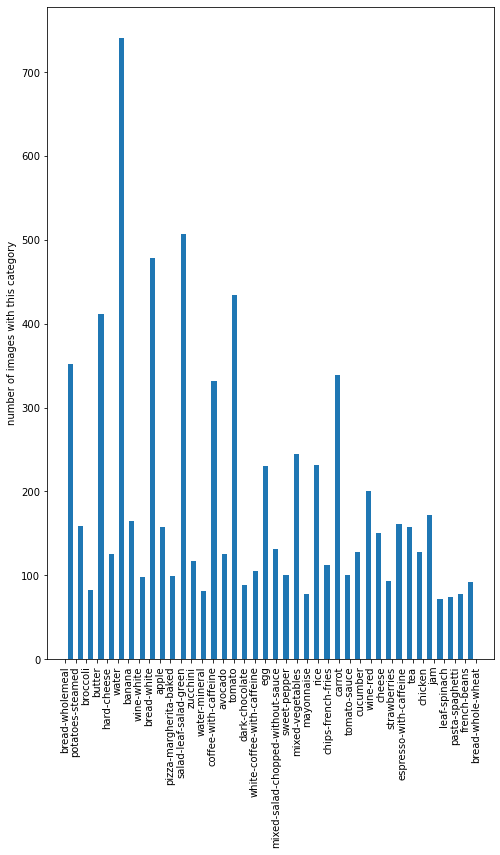

Category frequencies: [0.04550743 0.02055591 0.01073045 0.05326438 0.01616031 0.09579832 0.02133161 0.01266968 0.06179703 0.02042663 0.01279897 0.06554622 0.01512605 0.01047188 0.04292178 0.01616031 0.0561086  0.01150614
 0.01357466 0.02973497 0.01706529 0.01292825 0.03167421 0.01008403 0.02999354 0.01447964 0.04382676 0.01292825 0.01654816 0.02598578 0.01939237 0.01202327 0.02081448 0.02042663 0.01654816 0.02223659
 0.00930834 0.0095669  0.01008403 0.01189399]


In [34]:
category_frequencies = []

def show_category_frequencies():
  coco_categories_for_histogram = [coco_cat_id_to_name(anno["category_id"]) for anno in annotations]

  plt.figure(figsize=(8,12))
  hist, _, _ = plt.hist(coco_categories_for_histogram, len(category_names), rwidth=0.5)
  plt.ylabel("number of images with this category")
  plt.xticks(rotation=90)
  global category_frequencies
  category_frequencies = hist / hist.sum()
  plt.show()

show_category_frequencies()

print("Category frequencies:", category_frequencies)

In [35]:
if not "example mini image masks":
  example_mini_image_masks = np.zeros((N_CLASSES,3,3),dtype=SEG_DTYPE)

  example_mini_image_masks[2] = np.array([[1,1,1],[1,1,0],[1,0,0]])
  example_mini_image_masks[5] = np.array([[1,0,0],[1,1,0],[1,1,1]])

  print(example_mini_image_masks.shape)

  example_mini_image_masks[:6]

  for i in range(3):
    for j in range(3):
      print(f"{i},{j} -> ",fai_multi_cats_from_coco_ids.decode(example_mini_image_masks[:,i,j]))

35592 607 607


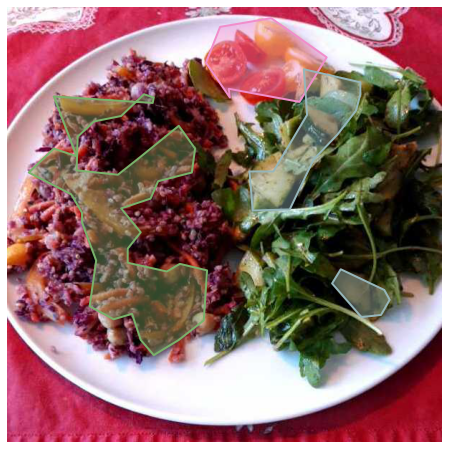

In [36]:
import skimage.io as io
imid = 30573
imid = 16387
imid = random.choice(image_ids)
im = coco.loadImgs(imid)[0]
im_annotations = coco.loadAnns(coco.getAnnIds(imgIds=imid))

image_path = os.path.join(Paths.TRAIN_IMAGES_DIR, im["file_name"])
plt.figure(figsize=(8,8))
I = io.imread(image_path)
plt.imshow(I)
plt.axis('off')
# Render annotations on top of the image
coco.showAnns(im_annotations)

print(imid,im["width"],im["height"])

In [37]:
def one_hot_id_from_coco_id(coco_id):
  return np.nonzero(fai_multi_cats_from_coco_ids([coco_id]))[0][0]

def convert_annotations_to_multimask(im_annotations, image_dict, debug=False):
  """Produces a mask of shape [N_CLASSES, w, h] where each seg_pixel (c,x,y) is either 1 (in class) or 0"""

  multi_seg_mask = np.zeros((N_CLASSES, image_dict["width"], image_dict["height"]),dtype=SEG_DTYPE)

  if debug:
    print("Image id", image_dict['id'])
    print("Image shape: ", image_dict['width'], image_dict['height'])

  for im_anno in im_annotations:
    encSeg = cocomask.frPyObjects(
        im_anno['segmentation']
        ,image_dict['width'], image_dict['height']
      )
    
    one_hot_id = one_hot_id_from_coco_id(im_anno["category_id"])
    
    if debug:
      print("Processing",im_anno['category_id'],"->",one_hot_id)
    
    org_seg = cocomask.decode(encSeg)

    if debug:
      print("Org seg shape ", org_seg.shape)
      print("Number of components of this label ", org_seg.shape[2])

    multi_component_segmentations = org_seg.reshape((image_dict['width'], image_dict['height'],-1))

    if debug:
      print("multi_component_segmentations.shape ", multi_component_segmentations.shape)

    category_seg = np.sum(multi_component_segmentations, axis=2)
    np.clip(category_seg,0,1,out=category_seg)

    assert category_seg.shape == (image_dict["width"],image_dict["height"])

    multi_seg_mask[one_hot_id] = category_seg

  return multi_seg_mask

Image id 35592
Image shape:  607 607
Processing 1022 -> 22
Org seg shape  (607, 607, 1)
Number of components of this label  1
multi_component_segmentations.shape  (607, 607, 1)
Processing 1069 -> 16
Org seg shape  (607, 607, 1)
Number of components of this label  1
multi_component_segmentations.shape  (607, 607, 1)
Processing 1056 -> 15
Org seg shape  (607, 607, 2)
Number of components of this label  2
multi_component_segmentations.shape  (607, 607, 2)
component = 0


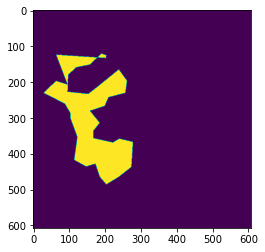

mask


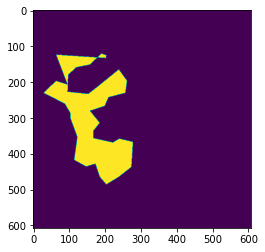

component = 0


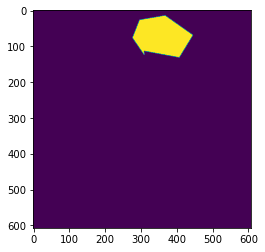

mask


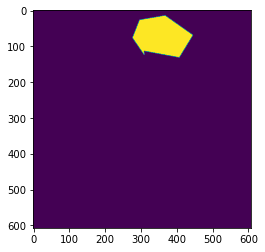

component = 0


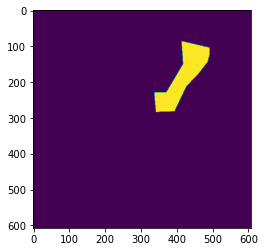

component = 1


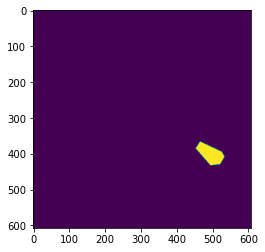

mask


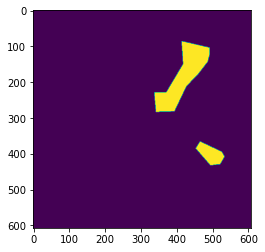

In [38]:
# test multi-label segmentation is correctly converted

import pycocotools
import pycocotools.mask as cocomask

result = convert_annotations_to_multimask(im_annotations,im,debug=True)

assert result.shape == (40, im["width"], im["height"])

for im_anno in im_annotations:
  encSeg = cocomask.frPyObjects(
      im_anno['segmentation']
      ,im['width'], im['height']
    )
  
  one_hot_id = one_hot_id_from_coco_id(im_anno['category_id'])

  m = cocomask.decode(encSeg)

  m = m.reshape((im['width'], im['height'], -1))
  for i in range(m.shape[2]):
    print("component =",i)
    plt.imshow(m[:,:,i])
    plt.show()
  
  print("mask")
  plt.imshow(result[one_hot_id])
  plt.show()

  assert np.all(m.sum(axis=2) == result[one_hot_id])

In [39]:
# Transform given annotations into our desired segmentations format

FORCE_RECOMPUTE = False

dest_segmentations_dir = None
def task(im_id):
  try:
    out_file = dest_segmentations_dir / f"{im_id}.npz"

    if os.path.isfile(out_file) and not FORCE_RECOMPUTE:
      return

    image_dict = coco.loadImgs(im_id)[0]
    im_annotations = coco.loadAnns(coco.getAnnIds(imgIds=im_id))
    multi_mask = convert_annotations_to_multimask(im_annotations, image_dict, debug=False)
    np.savez_compressed(out_file, multi_mask, allow_pickle=False)
  except Exception as e:
    print("Error: ", im_id)
    raise e

def preprocess_and_store_segmentations(im_ids):
  worker = prepareTask("task")
  with Pool(int(PAR_PROCS*3/2)) as p:
    with tqdm(total=len(im_ids)) as progress_bar:
      for _ in p.imap(worker, im_ids):
        progress_bar.update(1)


In [40]:
def load_multi_segmentation(path):
  arr = None
  with np.load(path) as npz:
    arr = npz["arr_0"]
  return arr

In [41]:
dest_segmentations_dir = Paths.CURR_MULTI_SEG_DIR
preprocess_and_store_segmentations(tiny_train_imids)
print(list(os.listdir(Paths.CURR_MULTI_SEG_DIR))[:5],"...")

  0%|          | 0/5545 [00:00<?, ?it/s]

['10034.npz', '10042.npz', '10045.npz', '10051.npz', '10052.npz'] ...


In [42]:
# TODO. optimize the above segmentation computation, as we can always reuse them from the training set
# or otherwise

In [43]:
if not "transform train data":
  dest_segmentations_dir = Paths.TRAIN_MULTI_SEG_DIR
  preprocess_and_store_segmentations(image_ids)
  print(list(os.listdir(Paths.TRAIN_MULTI_SEG_DIR))[:5],"...")

In [44]:
if FORCE_RECOMPUTE and not "we will not store it to google drive due ot it's slow read speed":
  store_directory_to_google_drive(Paths.TRAIN_MULTI_SEG_DIR)

In [45]:
def segmentation_size_fraction(seg):
  assert np.all(np.logical_or(seg == 0, seg == 1))
  assert seg.shape == (seg.shape[0],seg.shape[1])
  segSize = np.count_nonzero(seg)
  return float(segSize) / seg.size

def resize_mseg(mseg, debug=False):
  dest = np.zeros((N_CLASSES, IM_SZ,IM_SZ), dtype=SEG_DTYPE)
  for i in range(N_CLASSES):
    dest_seg_shape = (IM_SZ, IM_SZ)
    has_defined_segmentation_for_class = np.any(mseg[i] == 1)
    if not has_defined_segmentation_for_class:
      continue
    
    asimg = PIL.Image.fromarray(mseg[i]) # using autodetected PIL Image Modes: https://pillow.readthedocs.io/en/stable/handbook/concepts.html#concept-modes
    # Pillow Image resize: https://pillow.readthedocs.io/en/stable/reference/Image.html#PIL.Image.Image.resize
    resized = asimg.resize(dest_seg_shape, resample=PIL.Image.NEAREST)
    resized = (np.array(resized, dtype=SEG_DTYPE) > 0.5).astype(SEG_DTYPE)

    if debug:
      print("original",i)
      plt.imshow(mseg[i])
      plt.show()
      print("resized",i)
      plt.imshow(resized)
      plt.show()

    assert resized.shape == dest_seg_shape
    assert np.all(np.logical_or(resized == 0,resized == 1))

    if "check fraction of segmentation is approx. equal":
      org_frac = segmentation_size_fraction(mseg[i])
      new_frac = segmentation_size_fraction(resized)
      abs_diff = np.abs(new_frac - org_frac)
      assert abs_diff < 0.01, f"Segmentation size fraction has changed during resizing. i {i}, original {org_frac}, new {new_frac}"
    
    dest[i] = resized

  return dest
  
if not "show transformed segmentations for data":
  for fname in fnames:
    print(f"{Path(fname).stem}")
    mseg = load_multi_segmentation(Paths.CURR_MULTI_SEG_DIR/f"{Path(str(int(fname.stem)))}.npz")
    resize_mseg(mseg, debug=True)


In [46]:
ls("curr/images",n=10)

006446.jpg
006452.jpg
006483.jpg
006489.jpg
006493.jpg
006497.jpg
006498.jpg
006508.jpg
006512.jpg
006514.jpg


In [47]:
ls("curr/segmentations",n=10)

10034.npz
10042.npz
10045.npz
10051.npz
10052.npz
10054.npz
10057.npz
10079.npz
10085.npz
10088.npz


In [48]:
# fastai delegation decorator: https://www.fast.ai/2019/08/06/delegation/

SEED=1337
# Attempts at a multi-label segmentation loader for fastai
# How to write a data block: https://docs.fast.ai/tutorial.datablock.html#Building-a-DataBlock-from-scratch
class MultiLabelSegmentationDataLoaders(DataLoaders):
    @classmethod
    @delegates(DataLoaders.from_dblock)
    def from_label_func(cls, path, fnames, label_func, valid_pct=0.3, seed=None, codes=None, item_tfms=None, batch_tfms=None, **kwargs):
        "Create from list of `fnames` in `path`s with `label_func`."
        dblock = DataBlock(blocks=(ImageBlock, TransformBlock),
                           #todo. old: MaskBlock(codes=codes)), todo. set c = number of classes
                           splitter=RandomSplitter(valid_pct, seed=seed),
                           get_y=label_func,
                           item_tfms=item_tfms,
                           batch_tfms=batch_tfms)
        res = cls.from_dblock(dblock, fnames, path=path, **kwargs)
        return res
      
# class MultiLabelSegmentation(???): pass

if not "fails due to unsupported multi-label segmetations. images cannot be loaded from npy format anyways":
  # IGNORE ME!!
  dls = SegmentationDataLoaders.from_label_func(
      Paths.CURR_DATA_DIR, bs=8, fnames = get_image_files(Paths.CURR_IMAGES_DIR),
      label_func = lambda o: Paths.CURR_MULTI_SEG_DIR/f"{int(o.stem)}.npz",
      codes = category_ids
  )

IM_SZ = 256
resize_args = (IM_SZ, fastbook.ResizeMethod.Crop)

fnames = get_image_files(Paths.CURR_IMAGES_DIR)

BATCH_SZ = min(N // 2, 5) # NOTE. Batch size is small due to small initial training dataset
dls = MultiLabelSegmentationDataLoaders.from_label_func(
  Paths.CURR_DATA_DIR, bs=BATCH_SZ, fnames = fnames,
  label_func = lambda o: resize_mseg(load_multi_segmentation(Paths.CURR_MULTI_SEG_DIR/f"{int(o.stem)}.npz")),
  codes = category_ids,
  item_tfms=Resize(*resize_args), # todo. actual resizing needs to happen here
  seed = SEED
)


Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


In [49]:
from fastbook import ResizeMethod

In [50]:
print("train",dls.train.n,dls.train.n_subsets)

print("valid",dls.valid.n,dls.valid.n_subsets)

assert len(dls.train) >= 1, "Training data generator is empty. Ensure, that the batch-size is small enough."
assert len(dls.valid) >= 1, "Validation data generator is empty. Ensure that the batch-size is small enough."

train 3882 2
valid 1663 2


In [51]:
# category balancing for BCELogitsLoss and variants
# https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html

category_weights = tensor((1 - category_frequencies) / category_frequencies, dtype=torch.float16)
# e.g. category_frequency = [0.3, 0.7]
# cat_rest_freq = [0.7, 0.3]
# weight = [2.33, 0.428]
category_weights_normalised = category_weights / category_weights.sum()

print(category_weights)


tensor([ 20.9744,  47.6478,  92.1928,  17.7743,  60.8800,   9.4386,  45.8788,  77.9286,  15.1820,  47.9557,  77.1313,  14.2564,  65.1111,  94.4938,  22.2982,  60.8800,  16.8226,  85.9101,  72.6667,
         32.6304,  57.5985,  76.3500,  30.5714,  98.1667,  32.3405,  68.0625,  21.8171,  76.3500,  59.4297,  37.4826,  50.5667,  82.1720,  47.0435,  47.9557,  59.4297,  43.9709, 106.4306, 103.5270,
         98.1667,  83.0761])


In [52]:
# learn = unet_learner(dls, resnet34) #cnn_learner

 # note. weights can be given here to balance out class-imbalance
crossEntropyLoss = torch.nn.CrossEntropyLoss(reduction='mean', weight=category_weights_normalised)
multiLabelMarginLoss = torch.nn.MultiLabelMarginLoss(reduction='mean')
mseLoss = lambda x, y: torch.mean(torch.linalg.vector_norm(x - y, dim=(1,2,3)))
bceLogitsLoss = torch.nn.BCEWithLogitsLoss(reduction='mean', pos_weight=category_weights.reshape((1,N_CLASSES,1,1)).to(device=DEVICE) )
# alt: tensor[np.newaxis,N_CLASSES,np.newaxis,np.newaxis]
# Bug with pytorch in pos_weight: https://discuss.pytorch.org/t/loss-function-for-multi-class-semantic-segmentation/40596?u=ptrblck


from enum import auto
class LossType(Enum):
  CROSS_ENTROPY = (auto(),crossEntropyLoss)
  MSE = (auto(), mseLoss)
  # MULTI_LABEL_MARGIN_LOSS = (auto(), multiLabelMarginLoss)
  BINARY_CROSS_ENTROPY_WITH_LOGITS_LOSS = (auto(), bceLogitsLoss)

  def apply(self, x, y):
    return self.value[1](x, y)

LOSS_FUNCTION = LossType.BINARY_CROSS_ENTROPY_WITH_LOGITS_LOSS

def loss_func(x,y):
  assert x.shape == y.shape
  assert x.shape[1:] == (N_CLASSES, IM_SZ, IM_SZ), f"Unexpected shape: {x.shape}"
  assert 1 <= x.shape[0] and x.shape[0] <= BATCH_SZ, f"Unexpected shape (batch): {x.shape}"
  
  result = LOSS_FUNCTION.apply(x, y)
  
  assert len(result.shape) == 0, f"Result should be scalar, but got: {result.shape}"
  return result

learn = unet_learner(
  dls, resnet34,
  n_out = N_CLASSES,
  pretrained=True,
  wd = 0.05,
  # normalize = true ?
  loss_func = loss_func # norm over segmentation. but sum over batch
  # todo. use proper loss here
  # lambda x, y: torch.mean torch.linalg.norm(x - y])
  # cnn: loss_func = lambda x, y: torch.linalg.norm(x - y[:,:,y.shape[2]//2,y.shape[3]//2]) # y.shape = (bs, N_CLASSES, IMG_SIZE, IMG_SIZE)
)

print(learn.model,learn.summary())

# todo. how might we make this a fully convolutional pipeline?

if False:
  unet_learner(
    dls, models.alexnet,
    normalize=True, n_out=len(category_ids),
    pretrained=True, config=None,
    loss_func=None, opt_func=Adam,
    lr=0.001, metrics=None,
    model_dir='models', train_bn=True,
    blur=False, blur_final=True,
    self_attention=False, y_range=None, last_cross=True,
    bottle=False, norm_type=None
  )

DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05

In [53]:
#learn.export(fname = "m00-resnet34-epoch5.pkl", pickle_module = dill, pickle_protocol = pickle.HIGHEST_PROTOCOL)

FORCE_TRAIN=False

m00 = "m00-resnet34-epoch5"
m01 = "m01-resnet34-epoch700"
m02 = "m02resnet34-epoch30-n1000"
m03 = "m02-resnet34-epoch20-n5545"
mcurr = "current" # only for temporary uage. not stored in storage

modelToTrain = m03

if modelToTrain in storage_list_artifacts() and not FORCE_TRAIN and modelToTrain != mcurr:
  storage_retrieve_artifact_by_name(modelToTrain)
  learn = learn.load(modelToTrain)
else:
  if modelToTrain == mcurr:
    learn.fine_tune(2)
  
  elif modelToTrain == m00:
    learn.fine_tune(5)
    learn.save(modelToTrain)
    
  elif modelToTrain == m01:
    learn.fine_tune(700)
    
  elif modelToTrain == m02:
    learn.fine_tune(30)
    
  elif modelToTrain == m03:
    learn.fine_tune(20)
    
  else:
    # learn.show_training_loop()
    # learn.fine_tune(10)
    # learn.fit_one_cycle(5)

    # learn.show_results()
    # todo. cannot show tensor multi-segmentation mask. need to define custom class for that
    raise NotImplementedError

  learn.save(modelToTrain)
  if modelToTrain != mcurr:
    storage_store_artifact_by_name(Path("curr") / "models" / (modelToTrain + ".pth"), modelToTrain, force=True)

epoch,train_loss,valid_loss,time
0,0.597644,0.567708,34:57


epoch,train_loss,valid_loss,time
0,0.385169,0.385717,34:25
1,0.370009,0.331076,32:45
2,0.316090,0.325406,33:04
3,0.343453,0.311177,33:05
4,0.291286,0.303063,33:15
5,0.288019,0.290760,33:17
6,0.296999,0.303433,33:07
7,0.278757,0.286883,32:47
8,0.243797,0.294009,32:39
9,0.226860,0.290274,33:08


Stored artifact for name m02-resnet34-epoch20-n5545 at Artificial_Intelligence/FoodRecChallenge/colab-storage/artifacts/m02-resnet34-epoch20-n5545.


In [ ]:
# TODOs.
# * early stopping
# * augmentation
# * show instance
# * loss curve plotting and saving

In [54]:
storage_list_artifacts()

['m00-resnet34-epoch5',
 'm01-resnet34-epoch700',
 'm02-resnet34-epoch20-n5545',
 'm02resnet34-epoch30-n1000']

In [55]:
ls("curr/models")

m00-resnet34-epoch5.pth
m01-resnet34-epoch700.pth
m02-resnet34-epoch20-n5545.pth
m02resnet34-epoch30-n1000.pth


In [56]:
print(torch.cuda.memory_summary())

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  678891 KB |    2266 MB |  131160 GB |  131159 GB |
|       from large pool |  644672 KB |    2223 MB |  129554 GB |  129554 GB |
|       from small pool |   34219 KB |      44 MB |    1605 GB |    1605 GB |
|---------------------------------------------------------------------------|
| Active memory         |  678891 KB |    2266 MB |  131160 GB |  131159 GB |
|       from large pool |  644672 KB |    2223 MB |  129554 GB |

In [57]:
def loss_func_single(x, y):
  assert x.shape == y.shape
  assert x.shape == (N_CLASSES,IM_SZ, IM_SZ)
  x = tensor(x, dtype=torch.float32).to(device=DEVICE)
  y = tensor(y, dtype=torch.float32).to(device=DEVICE)
  return loss_func(x[None,:], y[None,:])

In [58]:
matplotlib_colormaps = ['Greys', 'Purples', 'Blues', 'Greens', 'Oranges', 'Reds',
                      'YlOrBr', 'YlOrRd', 'OrRd', 'PuRd', 'RdPu', 'BuPu',
                      'GnBu', 'PuBu', 'YlGnBu', 'PuBuGn', 'BuGn', 'YlGn']

class_colormaps = (matplotlib_colormaps * 3)[:N_CLASSES]
# e.g. class_colormaps[2] = "Blues"

def show_multi_segmentation(seg, alpha = 0.4, max_colorbars=3):
  seg = np.array(seg)
  assert seg.shape == (N_CLASSES,IM_SZ,IM_SZ)

  colorbar_sources = []

  for i in range(N_CLASSES):
    is_defined_for_class = np.any(seg[i] != 0)
    if is_defined_for_class:
      print(class_colormaps[i],"<-",category_names[i])
      res = plt.imshow(seg[i], cmap=class_colormaps[i], alpha = alpha)

      if len(colorbar_sources) < max_colorbars:
        cbar = plt.colorbar(res)
        cbar.ax.set_ylabel(category_names[i])

      colorbar_sources.append(res)

    if i % len(matplotlib_colormaps) // 3 == 0:
      if len(colorbar_sources) >= 1:
        plt.show()
      colorbar_sources = []

In [59]:
def get_train_data(idx):
  input, ground_truth = dls.train_ds[idx]
  assert ground_truth.shape == (N_CLASSES, IM_SZ, IM_SZ)
  return input, ground_truth

def show_results(n=10):

  for i in range(min(n,len(dls.train_ds))):

    print(f"=================== i = {i} ====================")

    im, gt = get_train_data(i)

    plt.imshow(im)
    plt.show()

    full_dec_pred, _, _  = learn.predict(im)
    # predict return values: https://docs.fast.ai/learner.html#Learner.predict

    show_multi_segmentation(gt)
    plt.show()

    print("=================== PREDICTION ====================")

    threshold = 0.8
    show_multi_segmentation(np.array(full_dec_pred >= threshold, dtype=SEG_DTYPE), max_colorbars=3)
    plt.show()

    print("Ground truth loss:", loss_func_single(gt, gt))
    print("Prediction loss:", loss_func_single(full_dec_pred, gt))


=================== i = 0 ====================


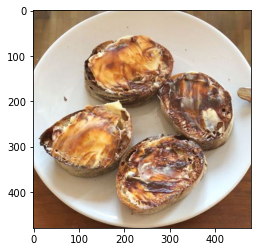

Greens <- butter
OrRd <- bread-white


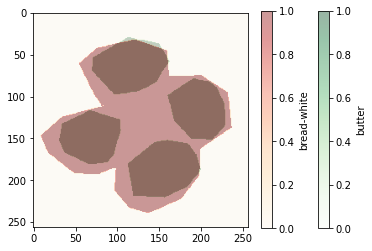

=================== PREDICTION ====================
Greys <- bread-wholemeal


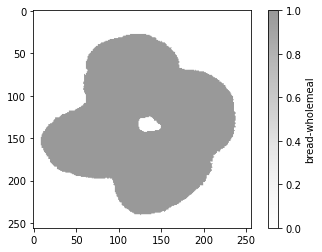

Greens <- butter
OrRd <- bread-white
YlGn <- dark-chocolate


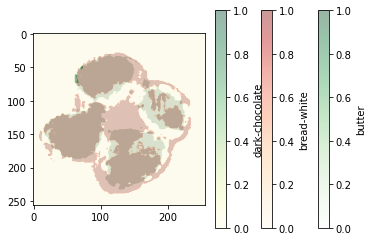

YlGn <- jam


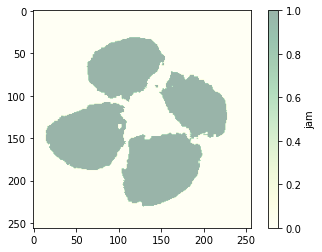

Greens <- bread-whole-wheat


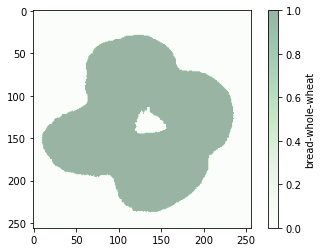

Ground truth loss: tensor(0.7656, device='cuda:0')
Prediction loss: TensorBase(0.1726, device='cuda:0')
=================== i = 1 ====================


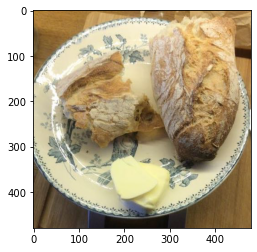

Greens <- butter
OrRd <- bread-white


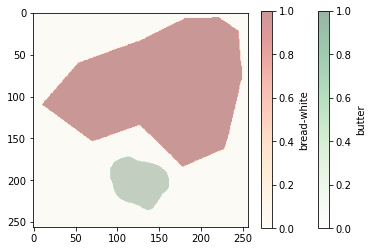

=================== PREDICTION ====================
Greys <- bread-wholemeal


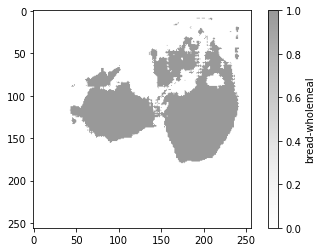

Greens <- butter
Oranges <- hard-cheese
YlOrBr <- banana
OrRd <- bread-white
PuRd <- apple
PuBuGn <- avocado


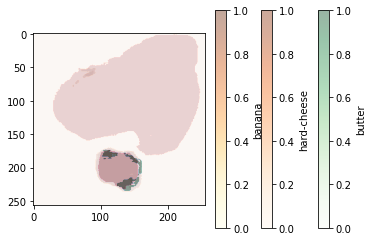

Purples <- egg


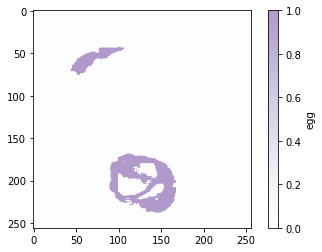

Reds <- mayonnaise
GnBu <- cheese


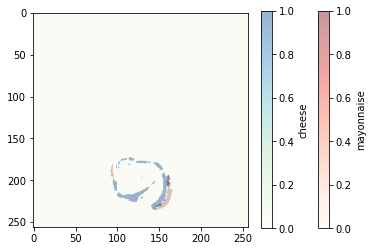

Greens <- bread-whole-wheat


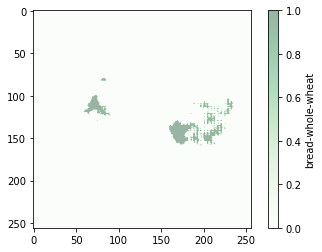

Ground truth loss: tensor(0.7399, device='cuda:0')
Prediction loss: TensorBase(0.0923, device='cuda:0')
=================== i = 2 ====================


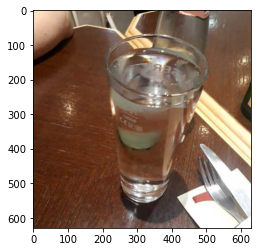

Reds <- water


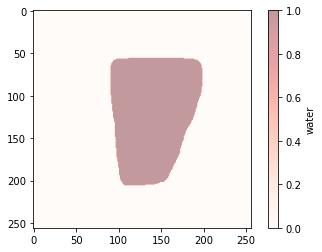

=================== PREDICTION ====================
Reds <- water
PuBu <- water-mineral


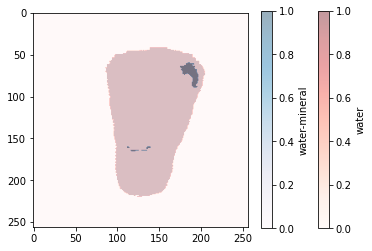

Ground truth loss: tensor(0.7044, device='cuda:0')
Prediction loss: TensorBase(0.0068, device='cuda:0')
=================== i = 3 ====================


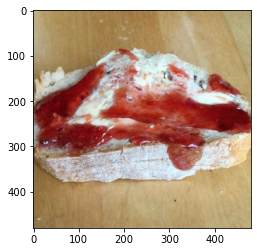

Greys <- bread-wholemeal


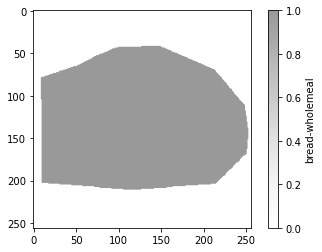

Greens <- butter


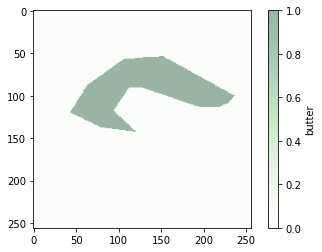

YlGn <- jam


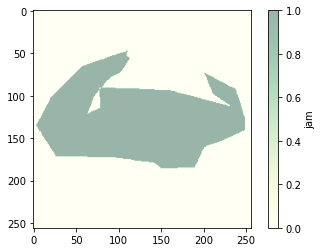

=================== PREDICTION ====================
Greys <- bread-wholemeal


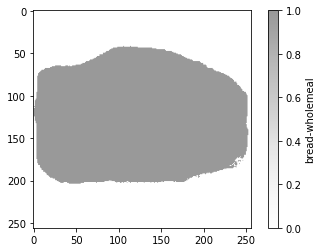

Greens <- butter
OrRd <- bread-white
YlGn <- dark-chocolate


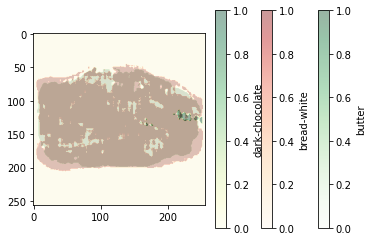

YlGn <- jam


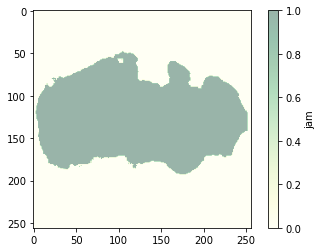

Greens <- bread-whole-wheat


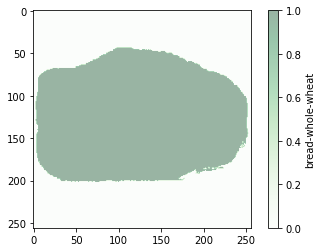

Ground truth loss: tensor(0.8824, device='cuda:0')
Prediction loss: TensorBase(0.1378, device='cuda:0')
=================== i = 4 ====================


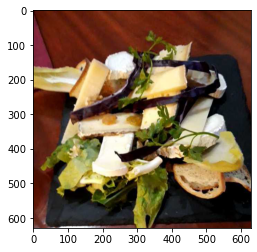

Oranges <- hard-cheese
BuPu <- salad-leaf-salad-green


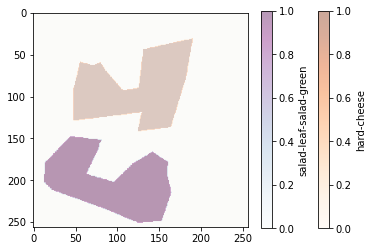

Greens <- bread-whole-wheat


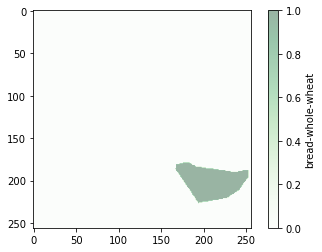

=================== PREDICTION ====================
Greys <- bread-wholemeal


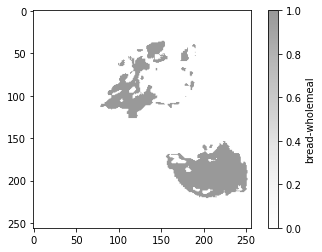

Purples <- potatoes-steamed


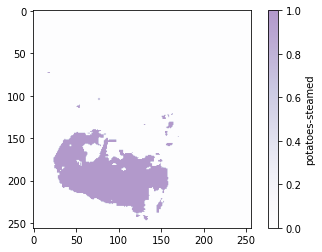

Greens <- butter
Oranges <- hard-cheese
YlOrBr <- banana
OrRd <- bread-white
PuRd <- apple
RdPu <- pizza-margherita-baked
BuPu <- salad-leaf-salad-green
GnBu <- zucchini
PuBuGn <- avocado


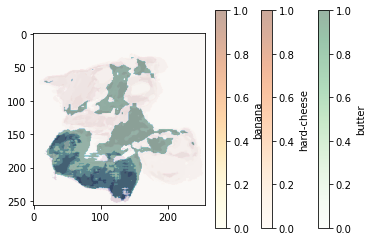

Purples <- egg


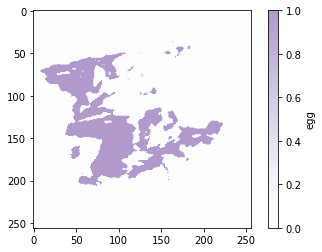

Reds <- mayonnaise
YlOrBr <- rice
RdPu <- cucumber
GnBu <- cheese
PuBu <- strawberries
BuGn <- chicken
YlGn <- jam


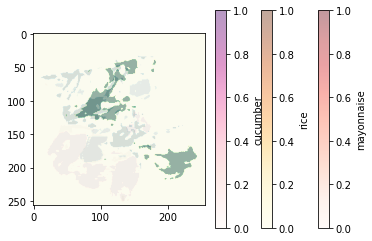

Greens <- bread-whole-wheat


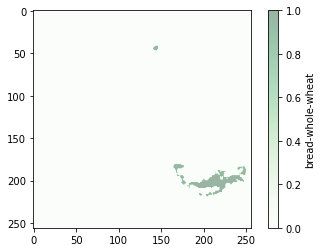

Ground truth loss: tensor(0.7923, device='cuda:0')
Prediction loss: TensorBase(0.4365, device='cuda:0')
=================== i = 5 ====================


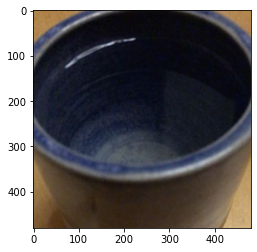

Reds <- water


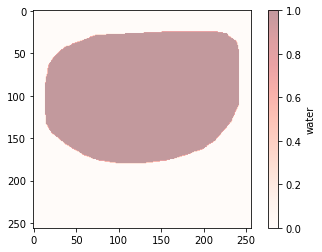

=================== PREDICTION ====================
Reds <- water
PuBu <- water-mineral


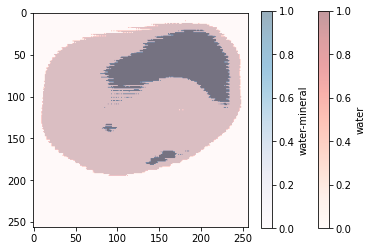

BuPu <- wine-red


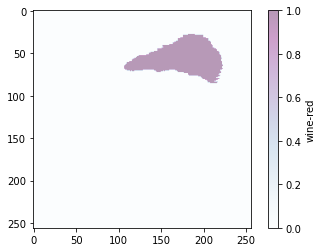

Ground truth loss: tensor(0.7195, device='cuda:0')
Prediction loss: TensorBase(0.0263, device='cuda:0')
=================== i = 6 ====================


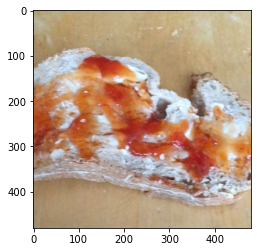

Greys <- bread-wholemeal


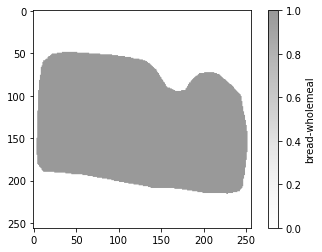

YlGn <- jam


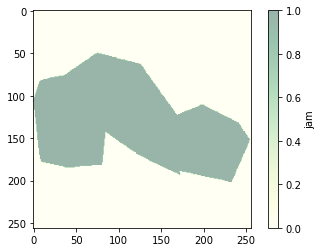

=================== PREDICTION ====================
Greys <- bread-wholemeal


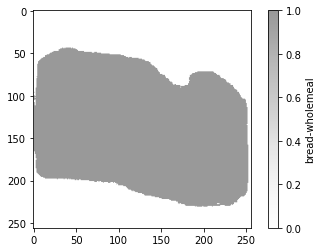

Greens <- butter
OrRd <- bread-white
YlGn <- dark-chocolate


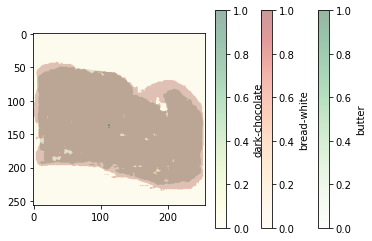

YlGn <- jam


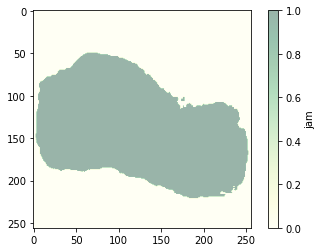

Greens <- bread-whole-wheat


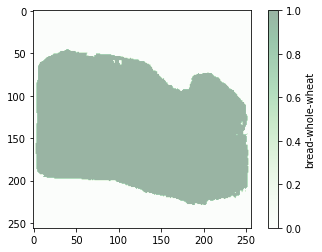

Ground truth loss: tensor(0.8818, device='cuda:0')
Prediction loss: TensorBase(0.1329, device='cuda:0')
=================== i = 7 ====================


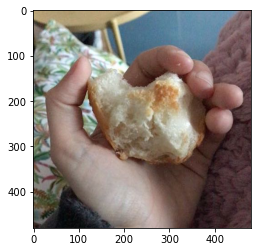

OrRd <- bread-white


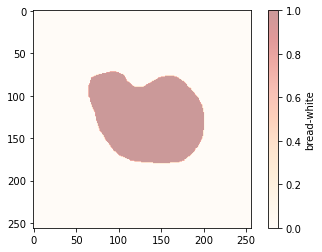

=================== PREDICTION ====================
Greys <- bread-wholemeal


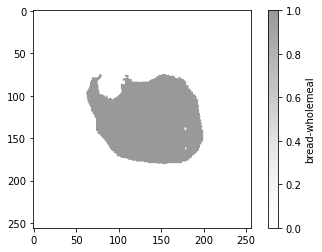

Greens <- butter
Oranges <- hard-cheese
OrRd <- bread-white


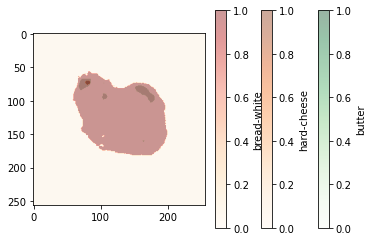

Purples <- egg


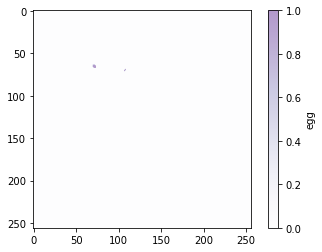

YlGn <- jam


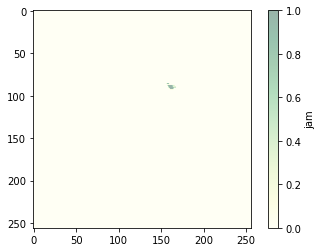

Greens <- bread-whole-wheat


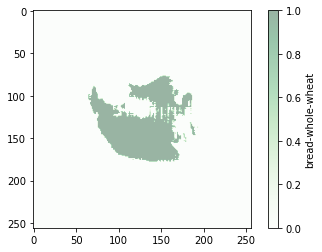

Ground truth loss: tensor(0.7107, device='cuda:0')
Prediction loss: TensorBase(0.0312, device='cuda:0')
=================== i = 8 ====================


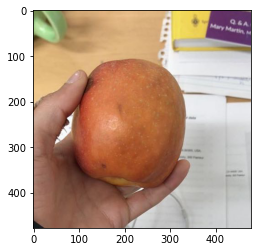

PuRd <- apple


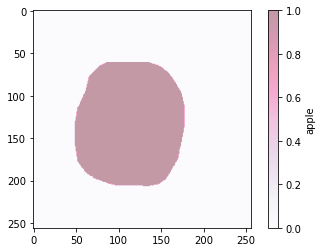

=================== PREDICTION ====================
Oranges <- hard-cheese
YlOrBr <- banana
OrRd <- bread-white
PuRd <- apple


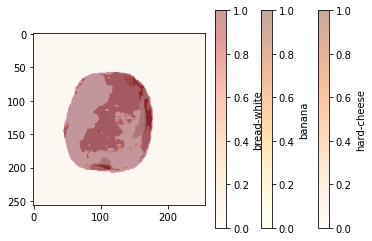

Purples <- egg


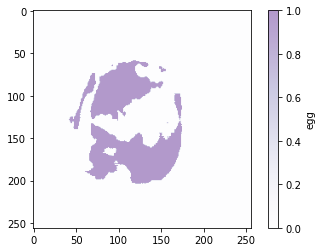

PuBu <- strawberries
YlGn <- jam


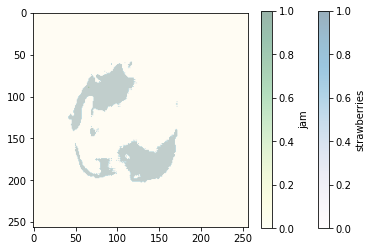

Ground truth loss: tensor(0.7803, device='cuda:0')
Prediction loss: TensorBase(0.0379, device='cuda:0')
=================== i = 9 ====================


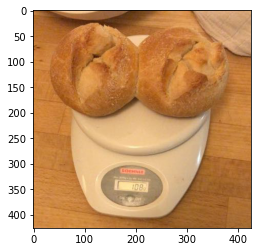

OrRd <- bread-white


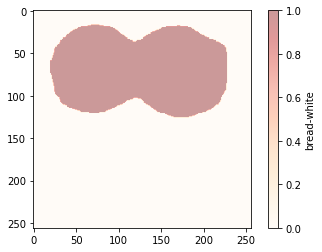

=================== PREDICTION ====================
Greys <- bread-wholemeal


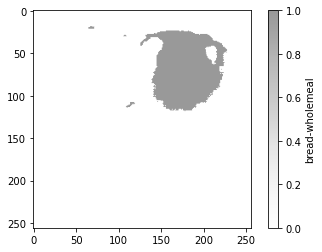

Greens <- butter
Oranges <- hard-cheese
YlOrBr <- banana
OrRd <- bread-white
PuRd <- apple


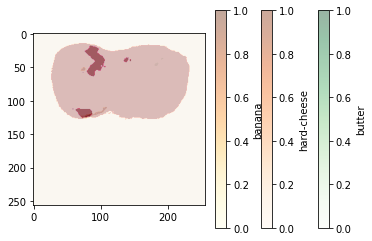

YlGn <- jam


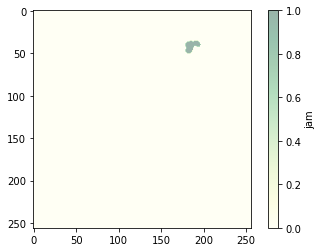

Greens <- bread-whole-wheat


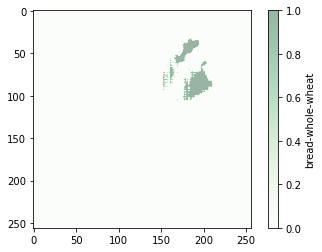

Ground truth loss: tensor(0.7214, device='cuda:0')
Prediction loss: TensorBase(0.0288, device='cuda:0')


In [60]:
show_results()

In [61]:
assert False, "NOTEBOOK_ENDS_HERE"

AssertionError: NOTEBOOK_ENDS_HERE

# Initialize detectron2

In [ ]:
_ = setup_logger()

register_coco_instances(DatasetLabels.TRAIN, {}, Paths.TRAIN_ANNOTATIONS, Paths.TRAIN_IMAGES_DIR)
register_coco_instances(DatasetLabels.VAL, {}, Paths.VAL_ANNOTATIONS, Paths.VAL_IMAGES_DIR)

# Build your Model 🏭

We will use Mask R-CNN to generate the segmentation masks for the food items 🌯

## Configure detectron2

Detectron2 has a variety of Instance Segmentation Models. We will use the zoo model with Mask RCNN + ResNet 50. If you want to try other models, you can find them [here]((https://github.com/facebookresearch/detectron2).

In [ ]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))

cfg.DATASETS.TRAIN = (DatasetLabels.TRAIN,)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 273  # Number of output classes

cfg.OUTPUT_DIR = "outputs"
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

## Load the pre-trained weights 

In [ ]:
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
cfg.SOLVER.IMS_PER_BATCH = 2

## Hyperparameters

In [ ]:
cfg.SOLVER.BASE_LR = 0.00025  # Learning Rate
cfg.SOLVER.MAX_ITER = 20000  # MAx Iterations
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128  # Batch Size

# Train the model 🚂

We will setup tensorboard to check the performance of the model while it is training.

## Setting up Tensorboard

In [ ]:
%load_ext tensorboard
%tensorboard --logdir outputs

## Train the Model

In [ ]:
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

# Evaluating the model 🧪

We will check the performance of our model on the validation dataset.

In [ ]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set the testing threshold for this model
cfg.DATASETS.TEST = (DatasetLabels.VAL, )
predictor = DefaultPredictor(cfg)

## Generate predictions on validation data 

In [ ]:
evaluator = COCOEvaluator(DatasetLabels.VAL, cfg, False, output_dir=cfg.OUTPUT_DIR)
data_loader = build_detection_test_loader(cfg, DatasetLabels.VAL)
results = inference_on_dataset(predictor.model, data_loader, evaluator)

## Visualizing the results 👓

Numbers are good, but visualizations are better!

In [ ]:
metadata = MetadataCatalog.get(DatasetLabels.VAL)

# Load the training annotations if not loaded
if not validation_annotations:
  with open(Paths.VAL_ANNOTATIONS) as json_file:
      annotations = json.load(json_file)

## Check the predictions

**Note:** If you are not able to see segmentation masks on the images, that generally means that the model didn't predict a mask for that image. You can verify this by doing

```python
predictions = predictor(img)
print(predictions)
```

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 180


# Visualize some random images
for i in range(8):
  image_filename = np.random.choice(validation_annotations.get("images")).get("file_name")
  image_filename = os.path.join(Paths.VAL_IMAGES_DIR, image_filename)

  img = cv2.imread(image_filename)
  predictions = predictor(img)

  v = Visualizer(img[:, :, ::-1],
    metadata=metadata, 
    scale=0.5, 
    # instance_mode=ColorMode.IMAGE_BW
  )
  annotated_image = v.draw_instance_predictions(predictions["instances"].to("cpu"))

  plt.subplot(2, 4, i+1)
  plt.axis('off')
  plt.imshow(annotated_image.get_image())

# A note on class ID mappings

Here is how the category object looks like

```json
{
  "id": 2578,
  "name": "water",
  "name_readable": "Water",
  "supercategory": "food"
}
```

Detectron2 usually maps the category IDs to contiguous numbers. For example, consider the following categories,

```json
[
  {
    "id": 2578,
    "name": "water",
    "name_readable": "Water",
    "supercategory": "food"
  },
  {
    "id": 1157,
    "name": "pear",
    "name_readable": "Pear",
    "supercategory": "food"
  },
  {
    "id": 2022,
    "name": "egg",
    "name_readable": "Egg",
    "supercategory": "food"
  }
]
```

Detectron internally maps these categories to something like

```json
{
  0: 2578, # detectron_id: actual_class_id
  1: 1157,
  2: 2022
}
```

So, when your model detects water, the prediction class ID that your model returns will be `0` and **not** `2578` . You should make sure to map these detectron IDs to their original actual class IDs for your submission to get scored properly.

Here's how you can get this mapping.

In [ ]:
coco_api = COCO(Paths.TRAIN_ANNOTATIONS)

category_ids = sorted(coco_api.getCatIds())
categories = coco_api.loadCats(category_ids)

class_to_category = { int(class_id): int(category_id) for class_id, category_id in enumerate(category_ids) }

with open("class_to_category.json", "w") as fp:
  json.dump(class_to_category, fp)

# Ready? Submit to AIcrowd 🚀

Now you can submit the trained model to AIcrowd!

## Submission configuration ⚙️

In [ ]:
aicrowd_submission = {
    "author": "<your name>",
    "username": "<your aicrowd username>",
    "description": "initial submission with detectron",
    "debug": False,
    "model_path": "outputs/model_final.pth",
    "model_type": "model_zoo",
    "model_config_file": "COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml",
    "detectron_model_config": {
      "ROI_HEADS": {
        "SCORE_THRESH_TEST": 0.5,
        "NUM_CLASSES": 273
      }
    }
}

aicrowd_submission["description"] = aicrowd_submission["description"].replace(" ", "-")
with open("aicrowd.json", "w") as fp:
  json.dump(aicrowd_submission, fp)

## Submit to AIcrowd

**Note:** We will create an SSH key on your google drive. This key will be used to identify you on gitlab.aicrowd.com.

In [ ]:
!bash <(curl -sL https://gitlab.aicrowd.com/jyotish/food-recognition-challenge-detectron2-baseline/raw/master/utils/submit-colab.sh)

# 📎 Important Links

* 💪 Challenge Page: https://www.aicrowd.com/challenges/food-recognition-challenge
* 🗣 Discussion Forum: https://discourse.aicrowd.com/c/food-recognition-challenge
* 🏆 Leaderboard: https://www.aicrowd.com/challenges/food-recognition-challenge/leaderboards  